# PageRank

"PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites." - <https://en.wikipedia.org/wiki/PageRank>

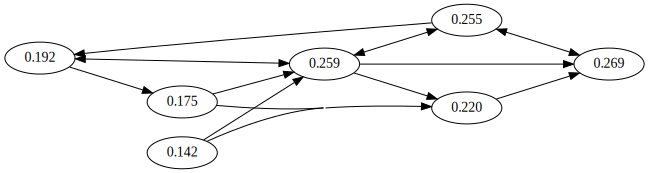

In [1]:
from pygraphblas import *
from pygraphblas.demo.gviz import draw

def pagerank(A, damping_factor, itermax):
    n = A.nrows
    d_out = A.reduce_vector()
    pr = Vector.from_type(FP32, n)
    pr[:] = 1.0/n
    teleport = (1 - damping_factor) / n
    for i in range(itermax):
        importance_vec = pr / d_out
        with Accum(binaryop.TIMES):
            importance_vec[:] = damping_factor
        importance_vec = A.transpose() @ importance_vec
        dangling_vec = pr[d_out]
        dangling_sum = dangling_vec.reduce_int() * (damping_factor / n)
        pr[:] = (teleport + dangling_sum)
        pr = pr + importance_vec
    return pr


M = Matrix.from_random(FP32, 7, 7, 30, no_diagonal=True, make_pattern=True, seed=42)

pr = pagerank(M, 0.35, 3)
draw(M, label_vector=pr, size_vector=pr, show_weight=False, label_width=5)

## PageRank 3f from GAP benchmarks

In [2]:

def pagerank3f(A, damping, itermax):
    n = A.nrows
    r = Vector.from_type(FP32, n)
    t = Vector.from_type(FP32, n)
    d = A.reduce_vector()
    d.assign_scalar(damping, accum=FP32.DIV)
    r[:] = 1.0 / n
    teleport = (1 - damping) / n
    tol = 1e-4
    rdiff = 1
    for i in range(itermax):
        if rdiff <= tol:
            break
        temp = t ; t = r ; r = temp
        w = t / d
        r[:] = teleport
        A.mxv(w, out=r, 
              accum=FP32.PLUS,
              semiring=FP32.PLUS_SECOND, 
              desc=TransposeA)
        t.assign(r, accum=FP32.MINUS)
        t = abs(t)
        rdiff = t.reduce_float()
    return r
    

In [3]:
pr = pagerank3f(M, 0.35, 3)

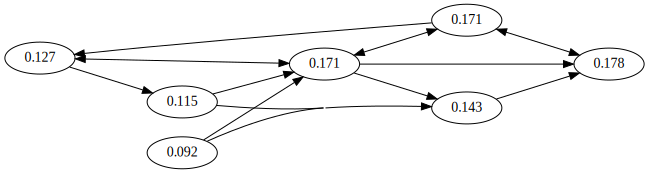

In [4]:
draw(M, label_vector=pr, size_vector=pr, show_weight=False, label_width=5)